# Imports:

In [1]:
import numpy as np
import scipy.special as special

import matplotlib.pyplot as plt

# Constants:

In [2]:
## 1 atm in Pa
ps0 = 1.01325e5

## MEDIUM CONSTANTS
medium_density = 1204 # in g / m^3
speed_in_medium = 343 # m / s

# Methods:

## Calculates absorption coefficients for vector of frequencies given conditions

In [3]:
def absorption(f, t=20, rh=60, ps=ps0):
    """ In dB/m
    
        f: frequency in Hz
        t: temperature in °C
        rh: relative humidity in %
        ps: atmospheric pressure in Pa

        From http://en.wikibooks.org/wiki/Engineering_Acoustics/Outdoor_Sound_Propagation
        See __main__ for actual curves.
    """
    
    if type(f) != int:
        f = f.reshape(1, len(f))
    if type(t) != int:
        t = t.reshape(len(t), 1)
    if type(rh) != int:
        rh = rh.reshape(len(rh), 1)
    T = t + 273.15
    T0 = 293.15
    T01 = 273.16

    Csat = -6.8346 * np.power(T01 / T, 1.261) + 4.6151
    rhosat = np.power(10, Csat)
    H = rhosat * rh * ps0 / ps

    frn = (ps / ps0) * np.power(T0 / T, 0.5) * (
            9 + 280 * H * np.exp(-4.17 * (np.power(T0 / T, 1/3.) - 1)))

    fro = (ps / ps0) * (24.0 + 4.04e4 * H * (0.02 + H) / (0.391 + H))

    alpha = f * f * (
        1.84e-11 / ( np.power(T0 / T, 0.5) * ps / ps0 )
        + np.power(T / T0, -2.5)
        * (
            0.10680 * np.exp(-3352 / T) * frn / (f * f + frn * frn)
            + 0.01278 * np.exp(-2239.1 / T) * fro / (f * f + fro * fro)
            )
        )

    return 20 * alpha / np.log(10)

## Initializes bat-related variables along with wavelength and *ka* values

In [4]:
### ASSUMING BAT GAPE HEIGHT OF 5-9MM IS PISTON DIAMETER
## a is piston radius
a = 0.003
bat_SL_in_dB = np.arange(110, 155, 5)
bat_frequencies = np.array([25000, 40000, 55000])
bat_dists = np.array([20.0, 20.0, 20.0])

## Initializes grid of x and y for bat-centric model along with respective r and theta

In [5]:
### THE BAT FLIGHT SPEED DICTATES THE INCREMENT BETWEEN EACH X AND Y.
### This does not need to be the case. For now, we can choose a small increment
### And later select the points to simulate "if the bat was moving faster"
bat_flight_speed = 0.1
x = np.arange(-100, 100+bat_flight_speed, bat_flight_speed)
x = x.reshape(1, x.shape[0])
y = np.arange(100, -100-bat_flight_speed, -bat_flight_speed)
y = y.reshape(y.shape[0], 1)


### SET Z AS 0 EVEN THOUGH WE DONT USE IT
z = 0

### CALCULATE THE RADIAL DISTANCE AND ANGLE THAT BAT IS TO MICROPHONE
r = np.sqrt((x**2) + (y**2))
theta = np.arctan(x/y)+1e-12


### SET 0 VALUES TO 1E-2 SO WE AVOID DIVIDE-BY-ZERO ERROR
r_inds = np.where(np.isclose(r,0, atol=1e-4))
min_dist = 1e-2
r[r_inds] = min_dist

### CHECK SHAPES
r.shape, theta.shape

((2001, 2001), (2001, 2001))

## Shows the absorption coefficient curves where I highlight the coefficient I will be using

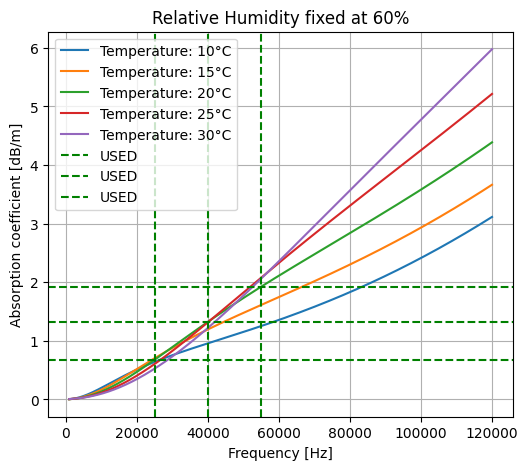

In [6]:
fs = np.linspace(int(1e3), int(1.2e5), int(1e3), endpoint=True)
t = np.arange(10, 35, 5)
t_labels = []
for temp in t:
    t_labels.append(f'Temperature: {temp}°C')
ys = absorption(fs, t=t)
plt.figure(figsize=(6, 5))
plt.rcParams.update({'font.size':10})
fs = fs * np.ones((len(t), 1))
plt.title('Relative Humidity fixed at 60%')
plt.plot(fs.T, ys.T, label=t_labels)
for bat_frequency in bat_frequencies:
    plt.axhline(y=absorption(int(bat_frequency)), linestyle='dashed', color='g')
    plt.axvline(x=bat_frequency, linestyle='dashed', color='g', label='USED')
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Absorption coefficient [dB/m]')
plt.legend()
plt.show()

## Below I plot the theta and r values of all possible microphones w.r.t. the bat

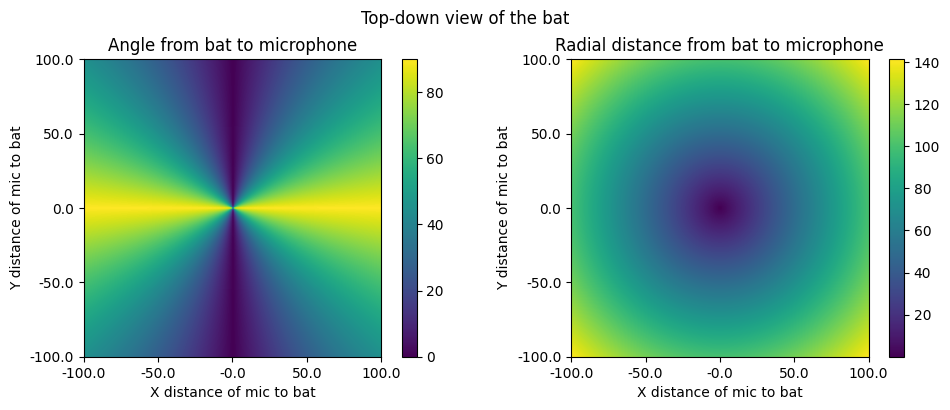

In [7]:
plt.figure(figsize=(10,4))

plt.suptitle('Top-down view of the bat')
plt.subplot(121)
plt.title('Angle from bat to microphone')
plt.imshow(np.abs(theta*(180/np.pi)))
step=int(50/bat_flight_speed)
plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
plt.ylabel('Y distance of mic to bat')
plt.xlabel('X distance of mic to bat')
plt.colorbar()

plt.subplot(122)
plt.title('Radial distance from bat to microphone')
plt.imshow(r)
plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
plt.ylabel('Y distance of mic to bat')
plt.xlabel('X distance of mic to bat')
plt.colorbar()

plt.tight_layout()
plt.show()

## Below I plot the directivity model I used for the bat's transmission beam pattern
This will tell us what any microphone placed around the bat will receive

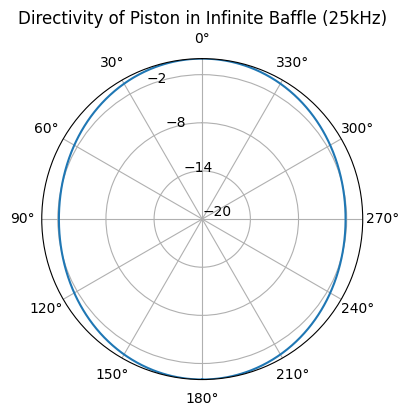

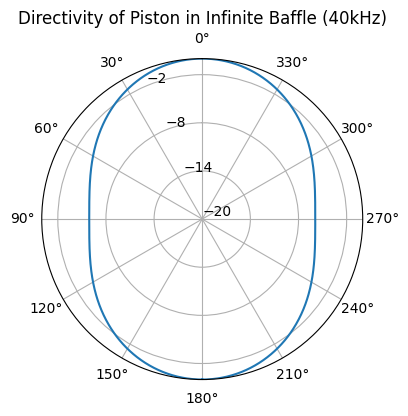

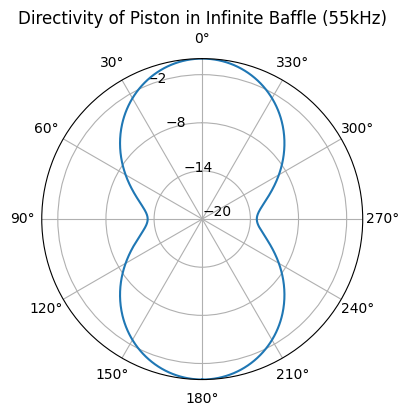

In [8]:
### Atmospheric attenuation found usinh Jakobsen at. al 2013
TL_dBs_for_bats = []
atm_dBs_for_bats = []
D_theta_dB_for_bats = []
spreading_dB_for_bats = []
for bat_frequency in bat_frequencies:

    ### FIND THE WAVENUMBER GIVEN THE BAT FREQUENCY AND MOUTH APERTURE
    wavelength = speed_in_medium / bat_frequency
    k = 2*np.pi/wavelength
    ka = k*a

    atmos_loss_DB = -1*absorption(int(bat_frequency))*r
    atm_dBs_for_bats += [atmos_loss_DB]

    ### Directivity for piston in infinite baffle using Beranek et. al 2019
    D_theta = 2*special.j1(ka*np.sin(theta))/(ka*np.sin(theta))
    D_theta_dB = 20*np.log10(np.abs(D_theta))
    clipped_D_theta_dB = np.clip(D_theta_dB, -24, None)
    D_theta_dB_for_bats += [D_theta_dB]

    ### Geometric Spreading calculated using Jakobsen et. al 2013
    spreading_dB = -20*np.log10(r)
    spreading_dB_for_bats += [spreading_dB]

    ### Frequency-dependent transmission loss!
    TL_dB_batfreq = spreading_dB+D_theta_dB+atmos_loss_DB 
    TL_dBs_for_bats += [TL_dB_batfreq]

    theta_polar = np.linspace(-np.pi, np.pi, 1000)
    theta_polar = theta_polar.reshape(theta_polar.shape[0], 1)
    D_theta_polar = 2*special.j1(ka*np.sin(theta_polar))/(ka*np.sin(theta_polar))
    D_theta_polar_dB = 20*np.log10(np.abs(D_theta_polar))

    fig = plt.figure(figsize=(8, 4))
    a0 = fig.add_subplot(121, projection='polar')
    a0.set_title(f"Directivity of Piston in Infinite Baffle ({bat_frequency//1000}kHz)")
    a0.plot(theta_polar, D_theta_polar_dB)
    a0.set_xticks(np.arange(0,2*np.pi,np.pi/6))
    a0.set_yticks(np.arange(-20,0,6))
    a0.set_ylim(-20, 0)
    a0.set_theta_zero_location('N')

    plt.tight_layout()
    plt.show()

## Below I plot the 3 separate losses that will be included in TL (transmission loss)
- Loss to atmosphere: This is caused due to atmospheric absorption of energy
- Loss to directivity: This is caused due to the directionality in transmission from the bat's emitter
- Loss to spreading: This is caused due to the spherical spreading of sound.

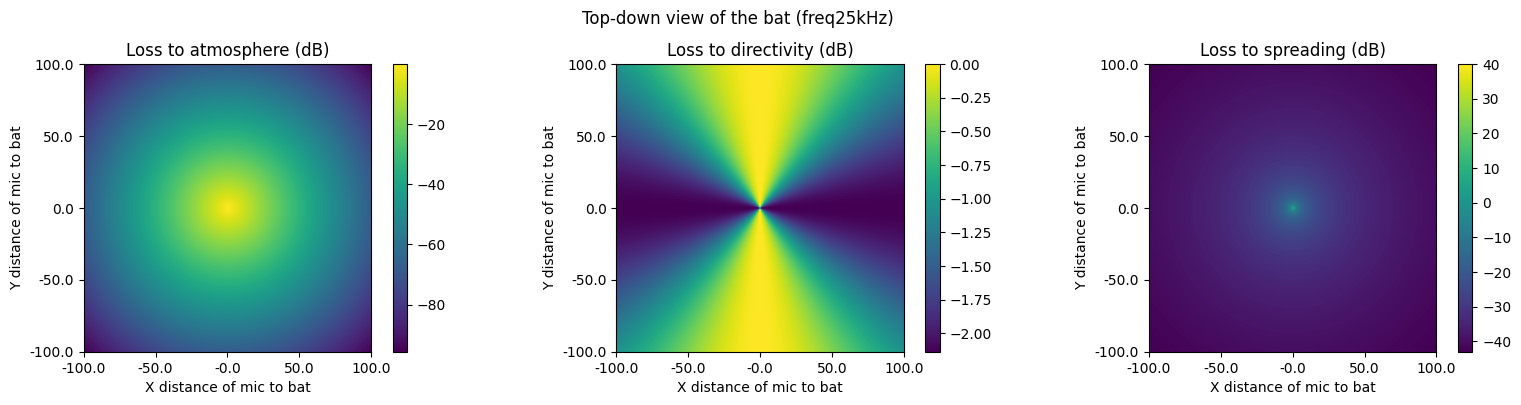

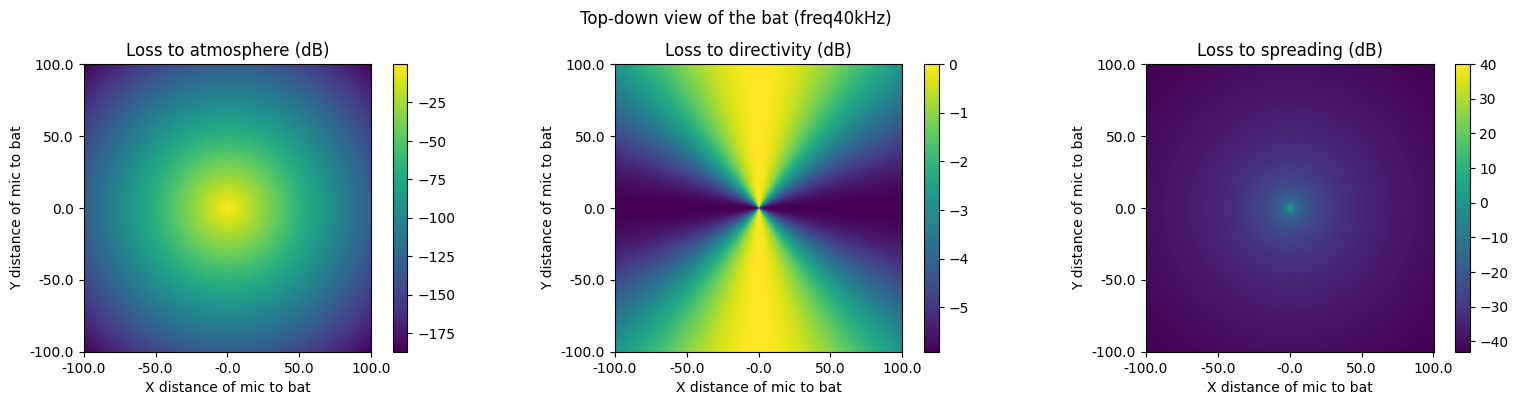

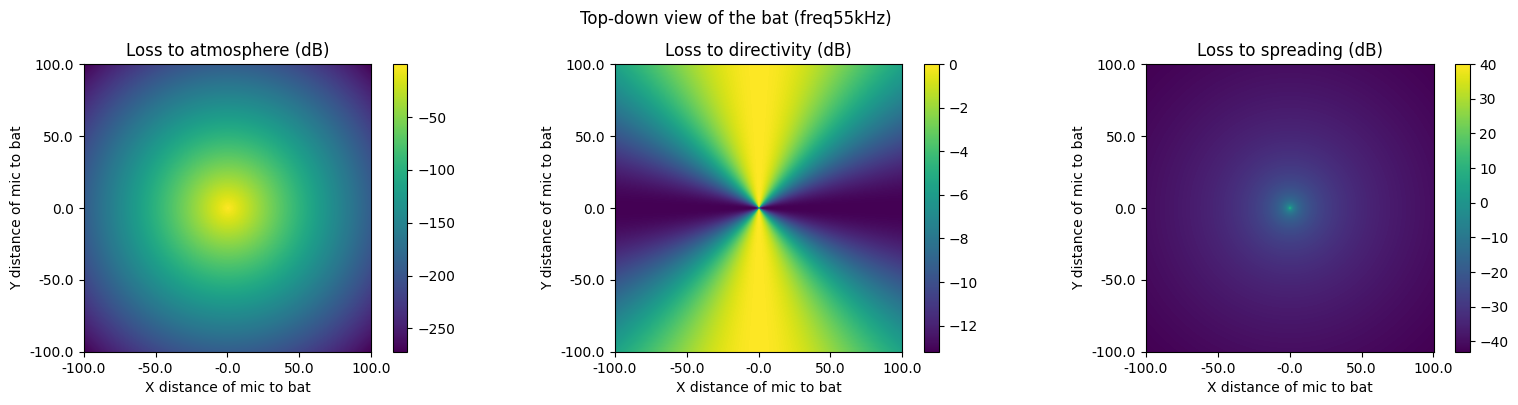

In [9]:
for i in range(0, len(bat_frequencies)):
    plt.figure(figsize=(16,4))

    plt.suptitle(f'Top-down view of the bat (freq{bat_frequencies[i]//1000}kHz)')
    plt.subplot(131)
    plt.title('Loss to atmosphere (dB)')
    plt.imshow(atm_dBs_for_bats[i])
    plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
    plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
    plt.ylabel('Y distance of mic to bat')
    plt.xlabel('X distance of mic to bat')
    plt.colorbar()

    plt.subplot(132)
    plt.title('Loss to directivity (dB)')
    plt.imshow(D_theta_dB_for_bats[i])
    plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
    plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
    plt.ylabel('Y distance of mic to bat')
    plt.xlabel('X distance of mic to bat')
    plt.colorbar()

    plt.subplot(133)
    plt.title('Loss to spreading (dB)')
    plt.imshow(spreading_dB_for_bats[i])
    plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
    plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
    plt.ylabel('Y distance of mic to bat')
    plt.xlabel('X distance of mic to bat')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

## Below I calculate the transmission loss (TL) and add it to the bat SL to get SPL for the microphone

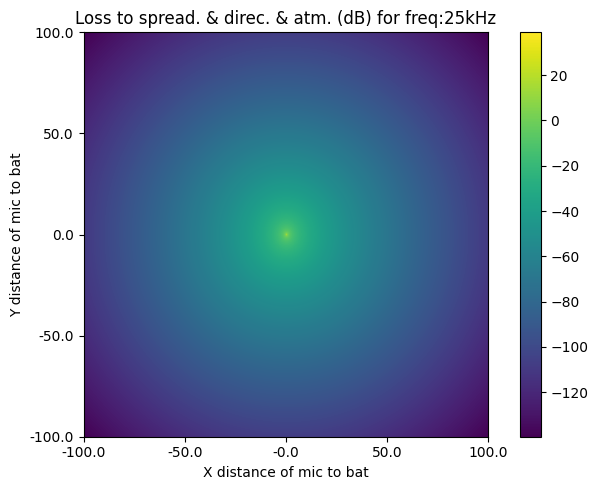

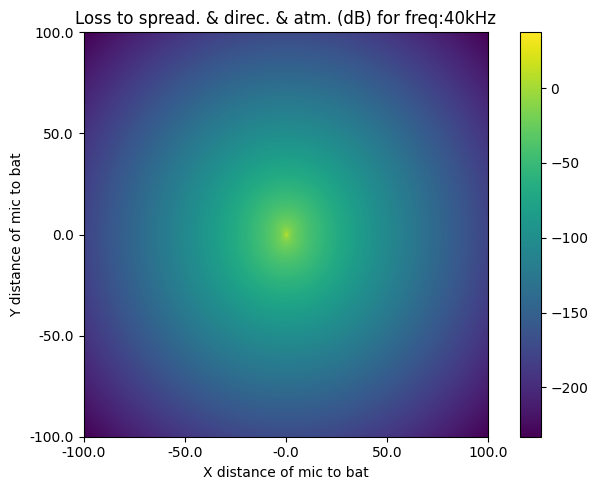

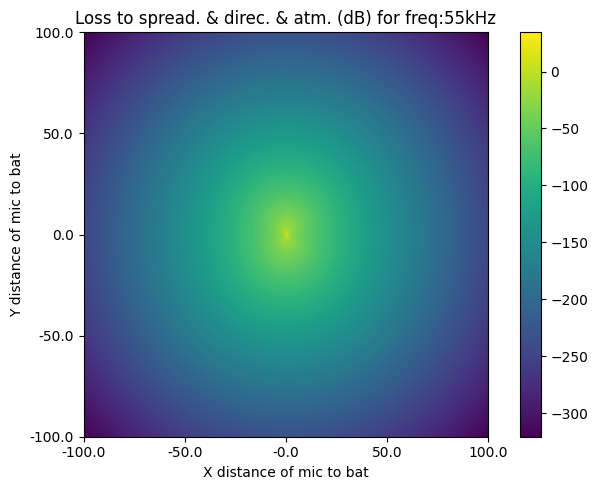

In [10]:
for i in range(0, len(bat_frequencies)):
    plt.figure(figsize=(7,5))

    plt.title(f'Loss to spread. & direc. & atm. (dB) for freq:{bat_frequencies[i]//1000}kHz')
    plt.imshow(TL_dBs_for_bats[i])
    plt.yticks(np.arange(len(y[:,0]))[::step], np.round(y[:,0][::step]))
    plt.xticks(np.arange(len(x[0]))[::step], np.round(x[0][::step]))
    plt.ylabel('Y distance of mic to bat')
    plt.xlabel('X distance of mic to bat')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

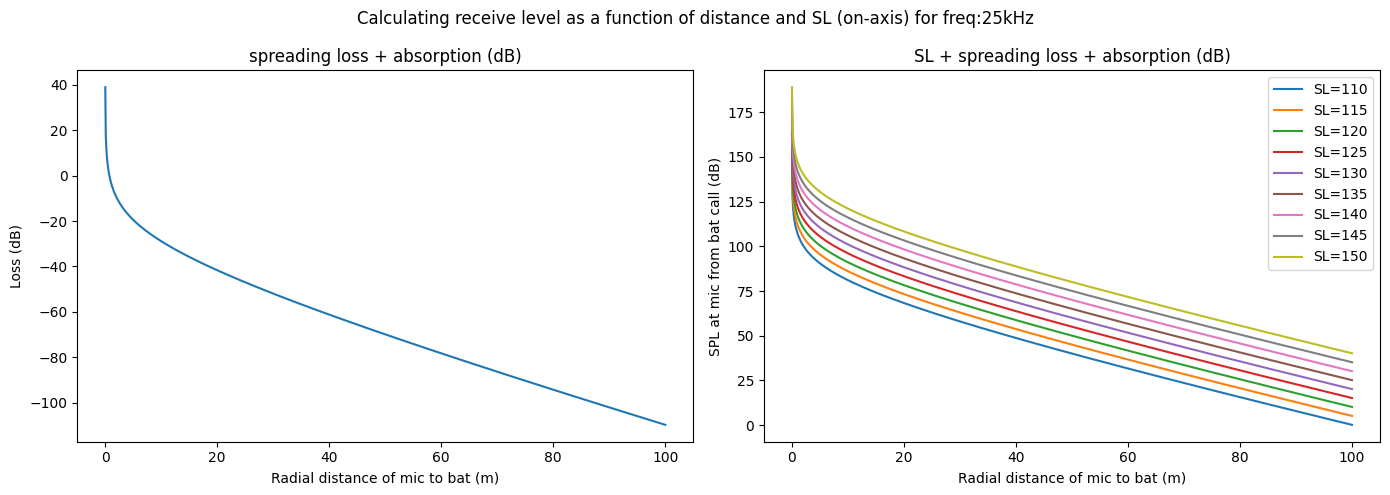

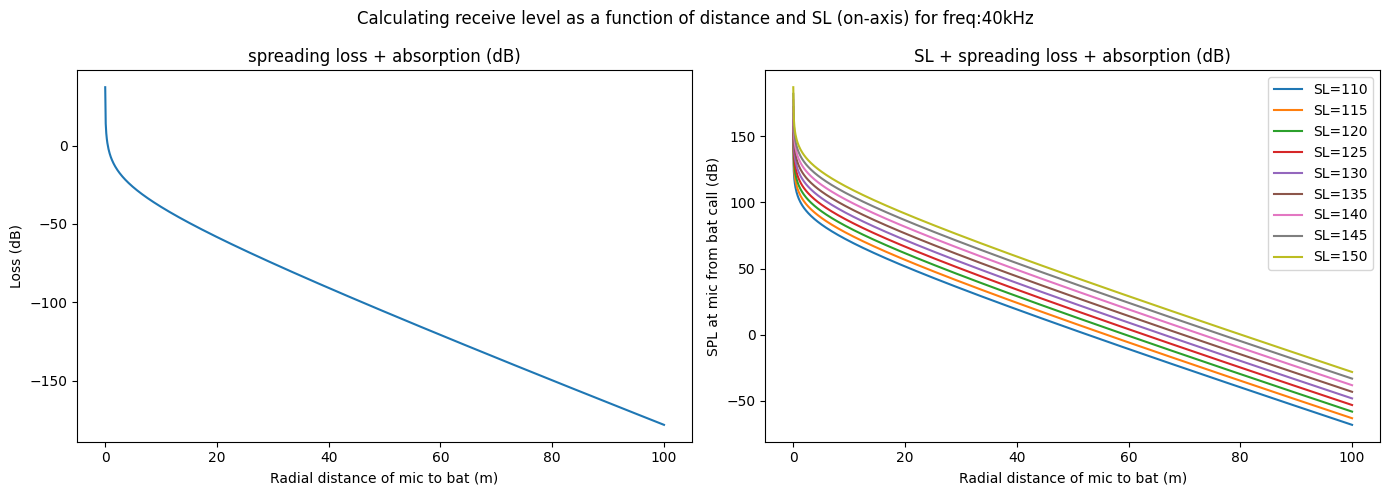

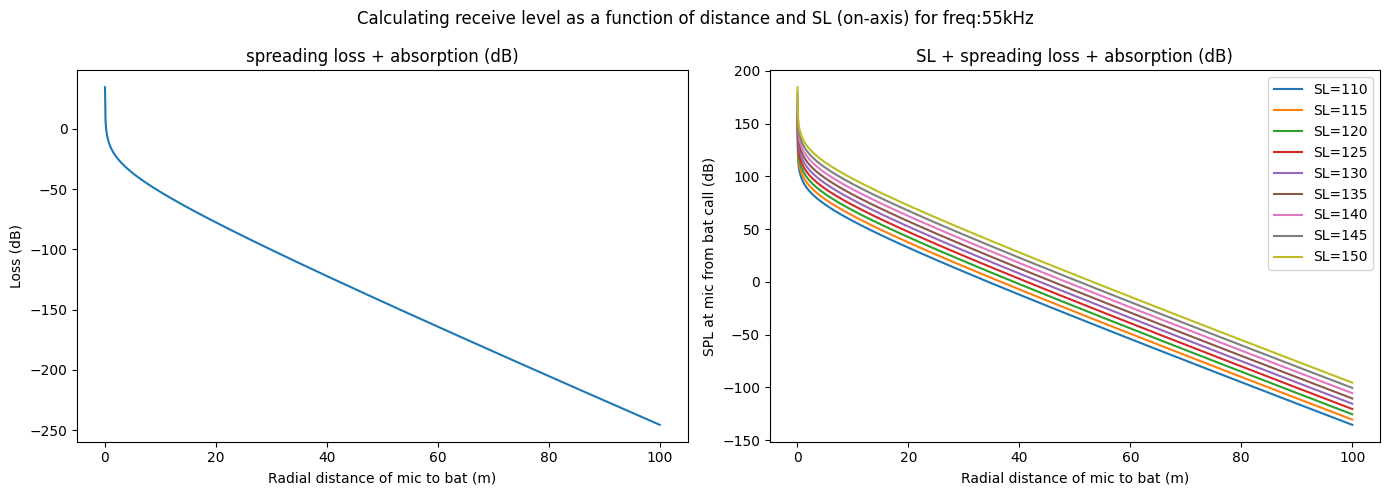

In [11]:
RL_dBs_for_bats = []
for i in range(0, len(bat_frequencies)):
    TL_dB = TL_dBs_for_bats[i]
    TL_along_r = TL_dB[np.where(np.isclose(x,0,atol=0.1))[1][0], np.where(np.isclose(y,0,atol=0.1))[0][0]:]
    respctive_r = r[np.where(np.isclose(x,0,atol=0.1))[1][0], np.where(np.isclose(y,0,atol=0.1))[0][0]:]

    RL_dB = TL_along_r.reshape(1,len(TL_along_r))+bat_SL_in_dB.reshape(len(bat_SL_in_dB),1) ### Receiver loss!
    RL_dBs_for_bats += [RL_dB]

    plt.figure(figsize=(14,5))

    plt.suptitle(f'Calculating receive level as a function of distance and SL (on-axis) for freq:{bat_frequencies[i]//1000}kHz')
    plt.subplot(121)
    plt.title('spreading loss + absorption (dB)')
    plt.plot(respctive_r, TL_along_r)
    plt.ylabel('Loss (dB)')
    plt.xlabel('Radial distance of mic to bat (m)')

    plt.subplot(122)
    plt.title('SL + spreading loss + absorption (dB)')
    plt.plot(respctive_r, RL_dB.T)
    plt.ylabel('SPL at mic from bat call (dB)')
    plt.xlabel('Radial distance of mic to bat (m)')
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    plt.tight_layout()
    plt.show()

In [12]:
def convertSPLtoV_at_dist(RLper20uPa, mic_sensitivity_dBVperPa, gain_setting_in_dB):
    dBperPa = 20*np.log10(20e-6)
    voltage = np.power(10, (RLper20uPa + dBperPa + mic_sensitivity_dBVperPa + gain_setting_in_dB)/20)

    return voltage

## Plugging in Audiomoth MEMS mic sensitivity and gain settings 
#### Sensitivity is -38dBV/Pa and gain is medium at -5.7dB with respect to high

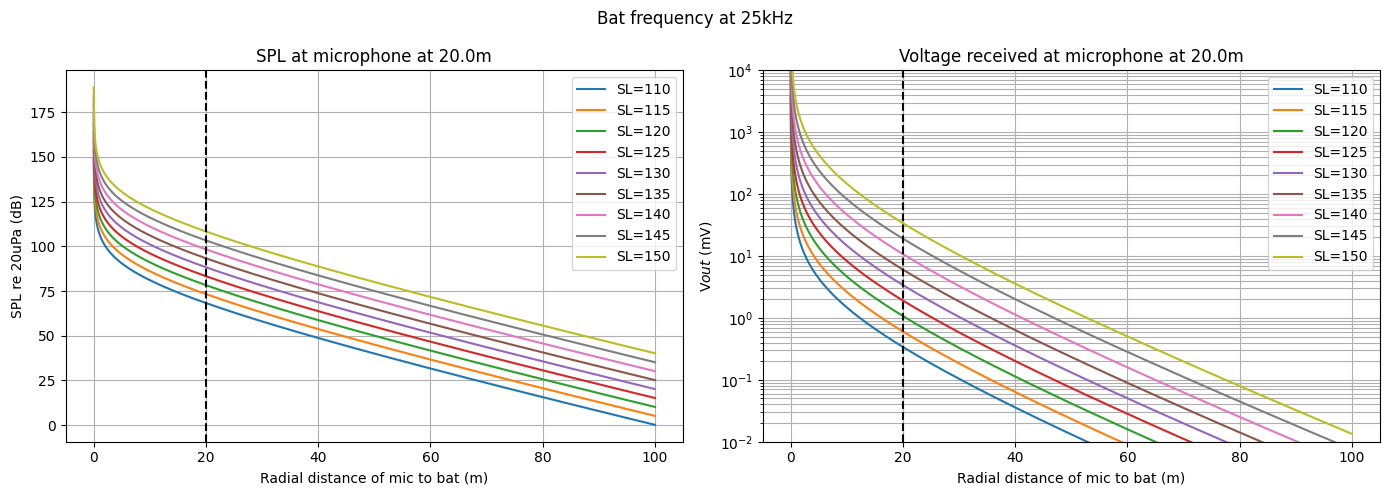

Voltages in mV: [[ 0.34011636  0.60482193  1.07554238  1.91261487  3.40116365  6.04821929
  10.75542383 19.12614874 34.01163649]]


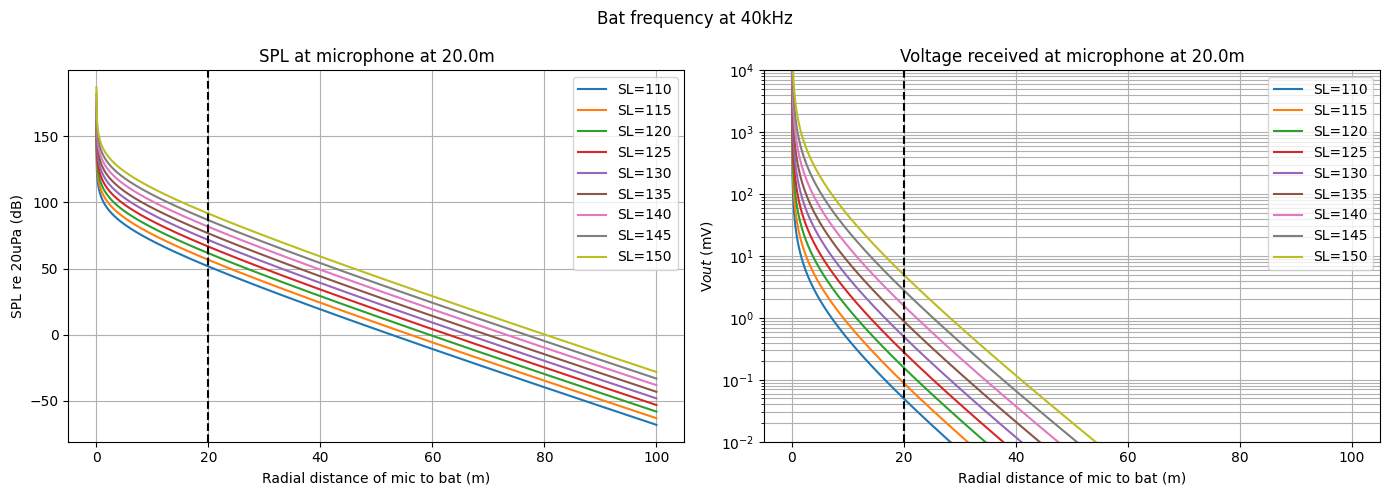

Voltages in mV: [[0.04958618 0.08817808 0.15680526 0.27884357 0.49586177 0.88178078
  1.56805261 2.78843567 4.95861774]]


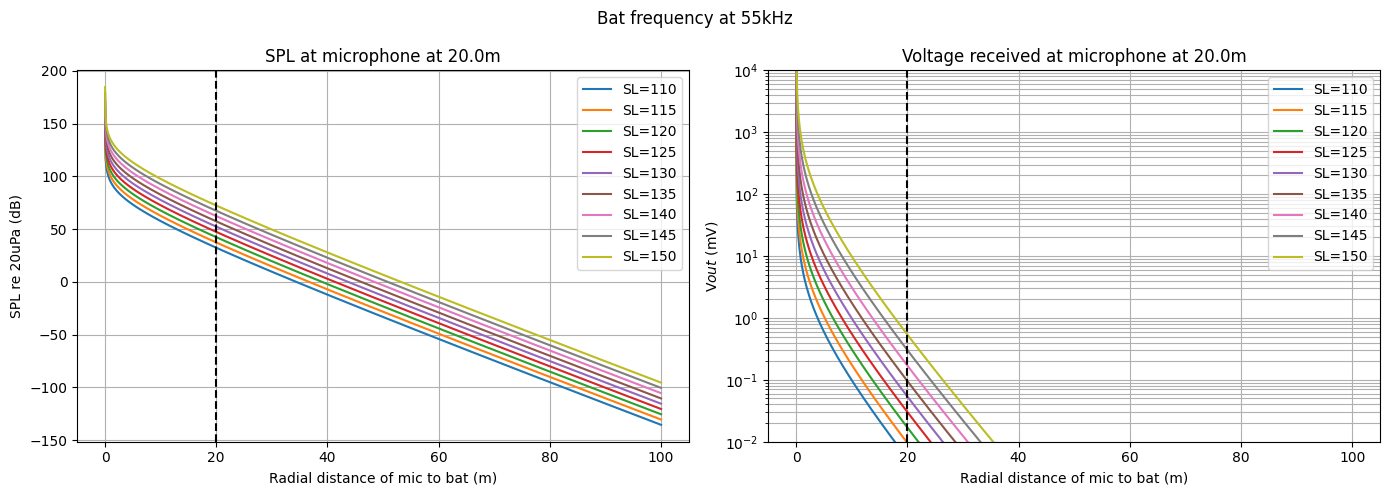

Voltages in mV: [[0.00538392 0.00957412 0.01702546 0.03027602 0.05383922 0.09574118
  0.17025457 0.3027602  0.53839224]]


In [13]:
for i in range(0, len(bat_frequencies)):
    dist = bat_dists[i]
    RLper20uPa = RL_dBs_for_bats[i]

    plt.figure(figsize=(14,5))
    plt.suptitle(f'Bat frequency at {bat_frequencies[i]//1000}kHz')
    plt.subplot(121)
    plt.title(f'SPL at microphone at {dist}m')
    plt.plot(respctive_r, RLper20uPa.T)
    plt.ylabel(r'SPL re 20uPa (dB)')
    plt.xlabel('Radial distance of mic to bat (m)')
    plt.axvline(x=dist, color='k', linestyle='dashed')
    plt.grid(which='both')
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    voltage_out = convertSPLtoV_at_dist(RLper20uPa, -38, -5.7).T

    plt.subplot(122)
    plt.title(f'Voltage received at microphone at {dist}m')
    plt.plot(respctive_r, (voltage_out*1000))
    plt.ylabel(r'V$out$ (mV)')
    plt.xlabel('Radial distance of mic to bat (m)')
    plt.axvline(x=dist, color='k', linestyle='dashed')
    plt.grid(which='both')
    plt.yscale('log')
    plt.ylim(1e-2, 1e4)
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    plt.tight_layout()
    plt.show()
    print(f'Voltages in mV: {(1000*voltage_out[np.where(np.isclose(respctive_r,dist,atol=0.01))[0],:])}')

## Plugging in Echometer Touch 2 Pro sensitivity and gain settings 
#### Sensitivity: -38 dBV/Pa, measured at 0 dB gain setting

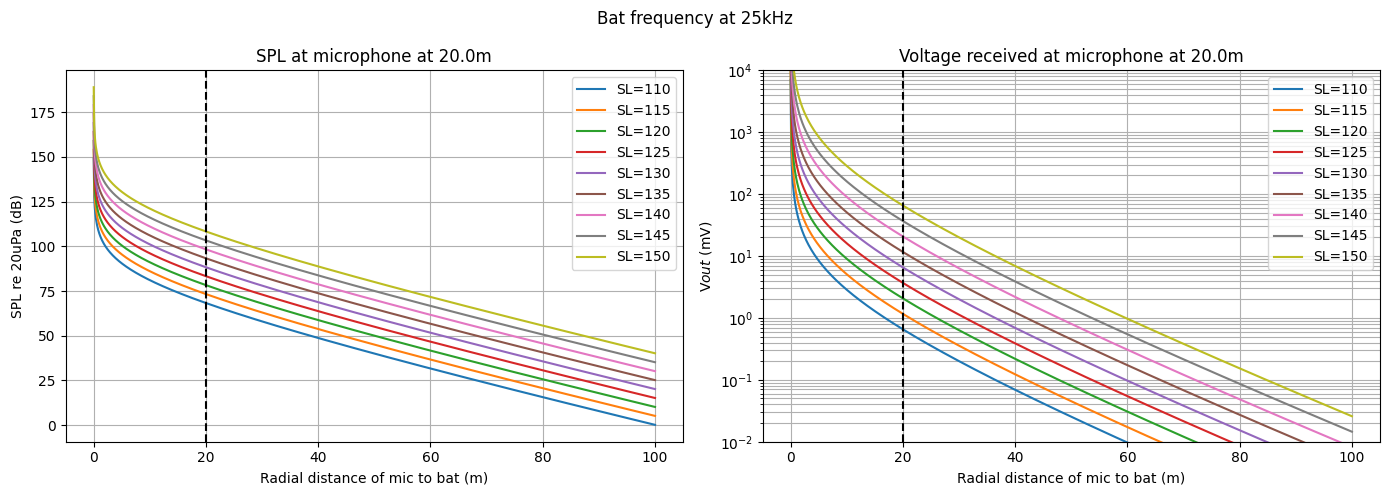

Voltages in mV: [[ 0.65558277  1.16580934  2.07313474  3.68661282  6.55582767 11.65809336
  20.73134738 36.86612819 65.55827668]]


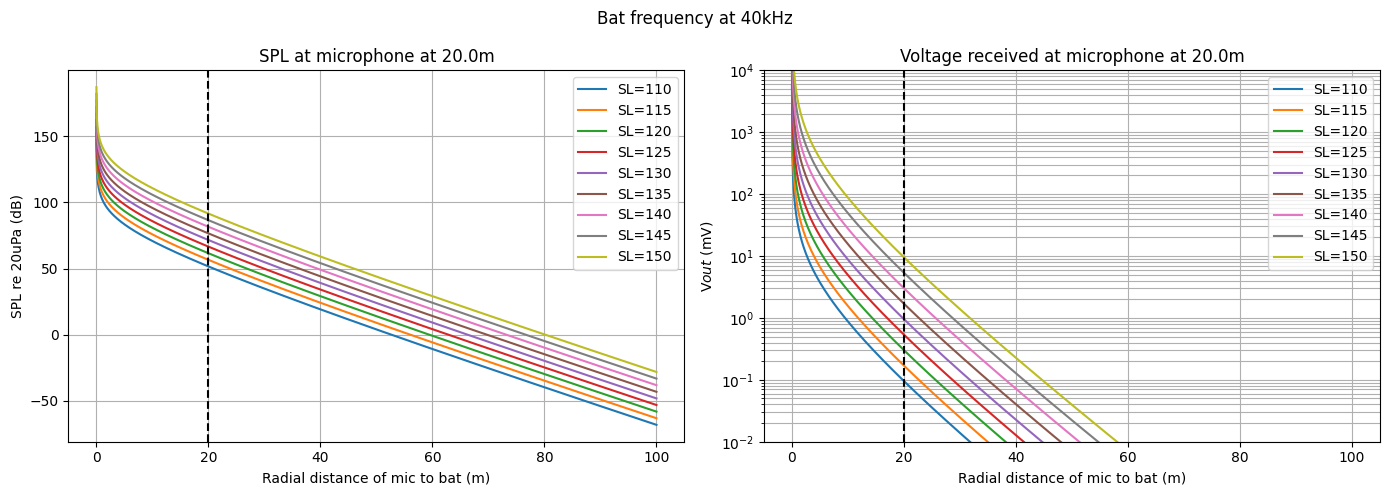

Voltages in mV: [[0.09557859 0.16996544 0.30224605 0.53747792 0.95578592 1.69965443
  3.02246047 5.37477923 9.55785923]]


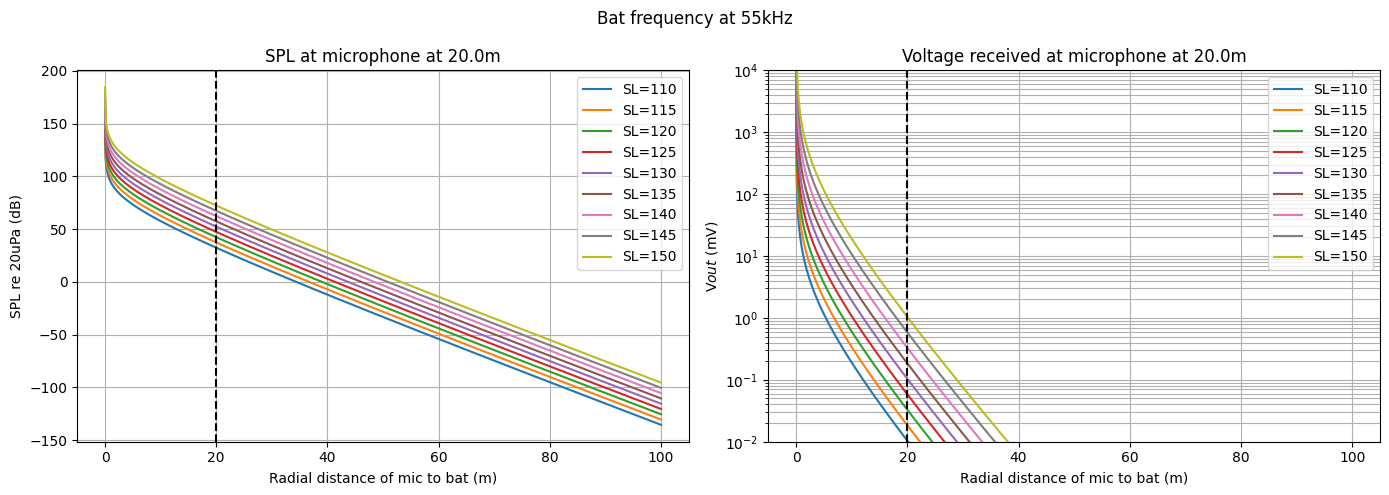

Voltages in mV: [[0.01037764 0.01845435 0.03281699 0.05835778 0.10377645 0.18454352
  0.32816993 0.58357784 1.03776445]]


In [14]:
for i in range(0, len(bat_frequencies)):
    dist = bat_dists[i]
    RLper20uPa = RL_dBs_for_bats[i]

    plt.figure(figsize=(14,5))
    plt.suptitle(f'Bat frequency at {bat_frequencies[i]//1000}kHz')
    plt.subplot(121)
    plt.title(f'SPL at microphone at {dist}m')
    plt.plot(respctive_r, RLper20uPa.T)
    plt.ylabel(r'SPL re 20uPa (dB)')
    plt.xlabel('Radial distance of mic to bat (m)')
    plt.axvline(x=dist, color='k', linestyle='dashed')
    plt.grid(which='both')
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    voltage_out = convertSPLtoV_at_dist(RLper20uPa, -38, 0).T

    plt.subplot(122)
    plt.title(f'Voltage received at microphone at {dist}m')
    plt.plot(respctive_r, (voltage_out*1000))
    plt.ylabel(r'V$out$ (mV)')
    plt.xlabel('Radial distance of mic to bat (m)')
    plt.axvline(x=dist, color='k', linestyle='dashed')
    plt.grid(which='both')
    plt.yscale('log')
    plt.ylim(1e-2, 1e4)
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    plt.tight_layout()
    plt.show()
    print(f'Voltages in mV: {(1000*voltage_out[np.where(np.isclose(respctive_r,dist,atol=0.01))[0],:])}')

## Plugging in SONG METER SM4BAT FS sensitivity and gain settings 
#### Sensitivity: -47 dBV re 1Pa, measured at 12 dB (default) gain setting

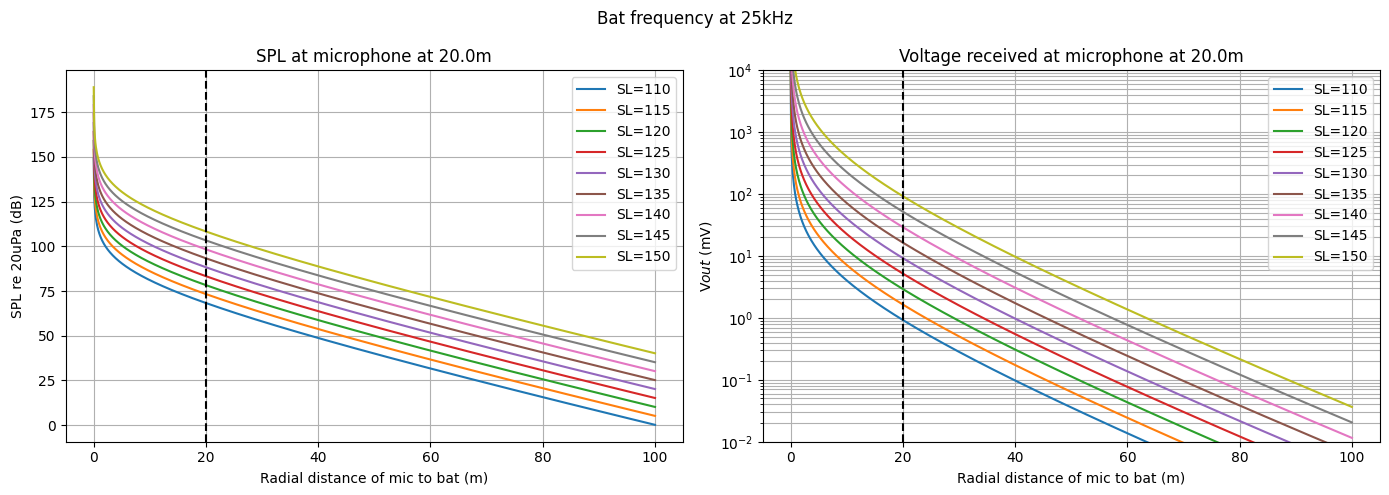

Voltages in mV: [[ 0.92603527  1.64674946  2.92838065  5.20747902  9.26035272 16.46749457
  29.28380652 52.07479019 92.60352717]]


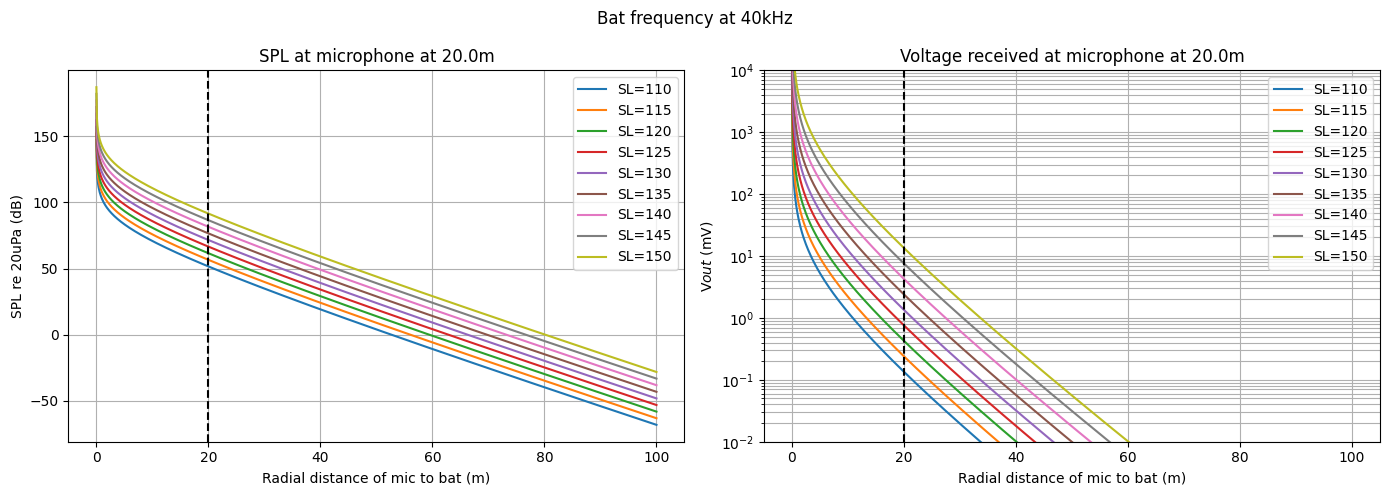

Voltages in mV: [[ 0.13500835  0.24008257  0.42693389  0.75920775  1.3500835   2.40082569
   4.26933889  7.59207745 13.50083501]]


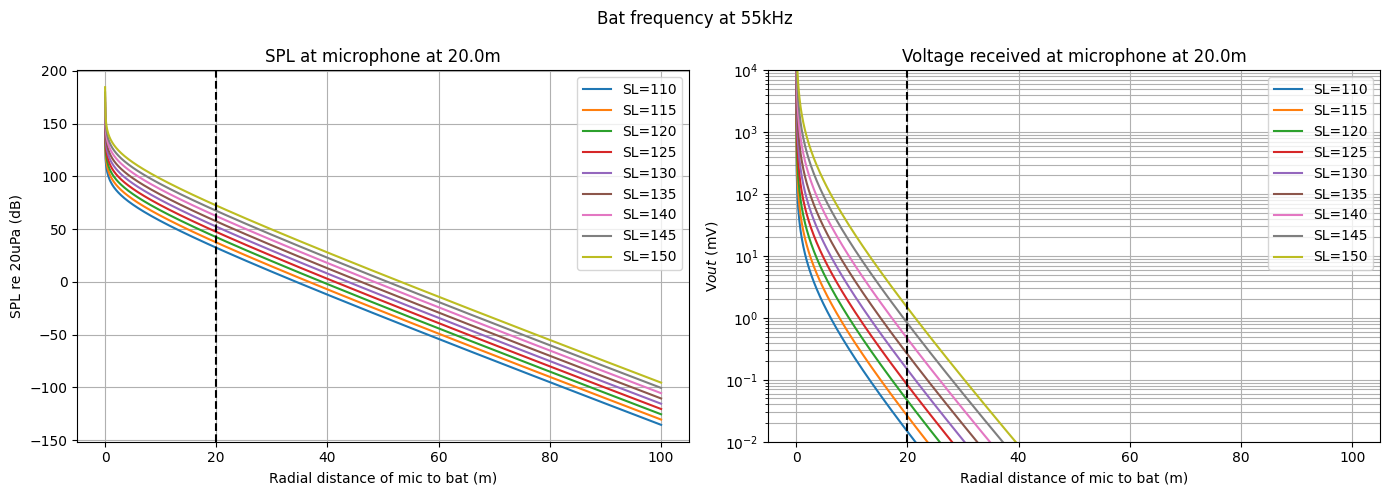

Voltages in mV: [[0.01465881 0.02606746 0.04635524 0.08243256 0.14658812 0.26067464
  0.46355235 0.8243256  1.46588125]]


In [15]:
for i in range(0, len(bat_frequencies)):
    dist = bat_dists[i]
    RLper20uPa = RL_dBs_for_bats[i]
    
    plt.figure(figsize=(14,5))
    plt.suptitle(f'Bat frequency at {bat_frequencies[i]//1000}kHz')
    plt.subplot(121)
    plt.title(f'SPL at microphone at {dist}m')
    plt.plot(respctive_r, RLper20uPa.T)
    plt.ylabel(r'SPL re 20uPa (dB)')
    plt.xlabel('Radial distance of mic to bat (m)')
    plt.axvline(x=dist, color='k', linestyle='dashed')
    plt.grid(which='both')
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    voltage_out = convertSPLtoV_at_dist(RLper20uPa, -47, 12).T

    plt.subplot(122)
    plt.title(f'Voltage received at microphone at {dist}m')
    plt.plot(respctive_r, (voltage_out*1000))
    plt.ylabel(r'V$out$ (mV)')
    plt.xlabel('Radial distance of mic to bat (m)')
    plt.axvline(x=dist, color='k', linestyle='dashed')
    plt.grid(which='both')
    plt.yscale('log')
    plt.ylim(1e-2, 1e4)
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    plt.tight_layout()
    plt.show()
    print(f'Voltages in mV: {(1000*voltage_out[np.where(np.isclose(respctive_r,dist,atol=0.01))[0],:])}')

## Plugging in Avisoft-Bioacoustics CM24/CMPA sensitivity and gain settings 
#### Approximate Sensitivity: 500mV/Pa, gain settings uncertain

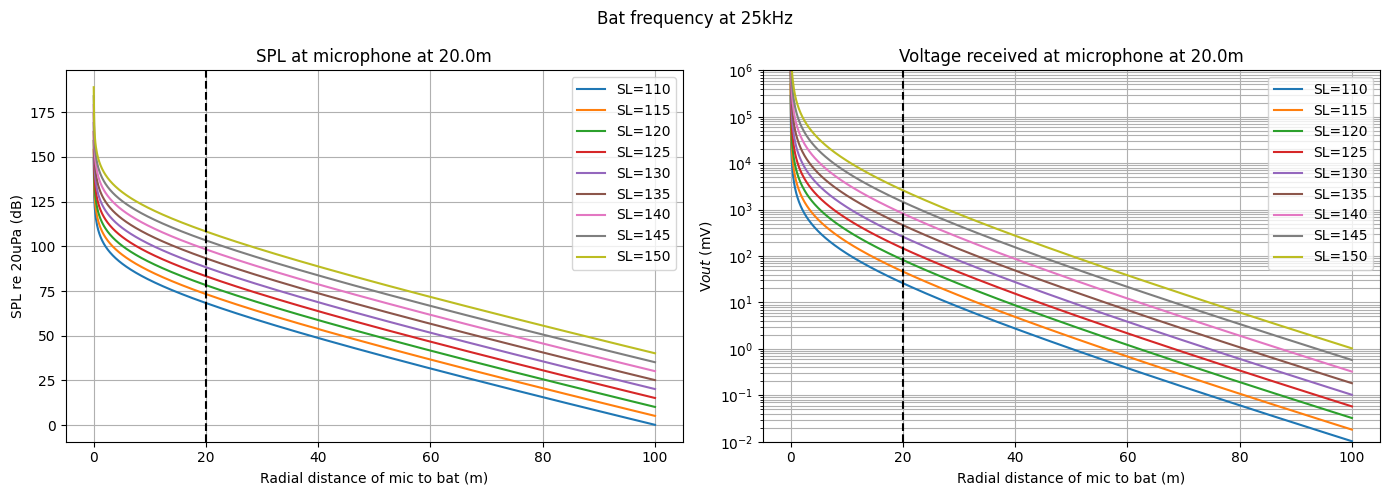

Voltages in mV: [[  26.03739509   46.30176359   82.33747283  146.41903261  260.37395093
   463.01763586  823.37472833 1464.19032613 2603.73950933]]


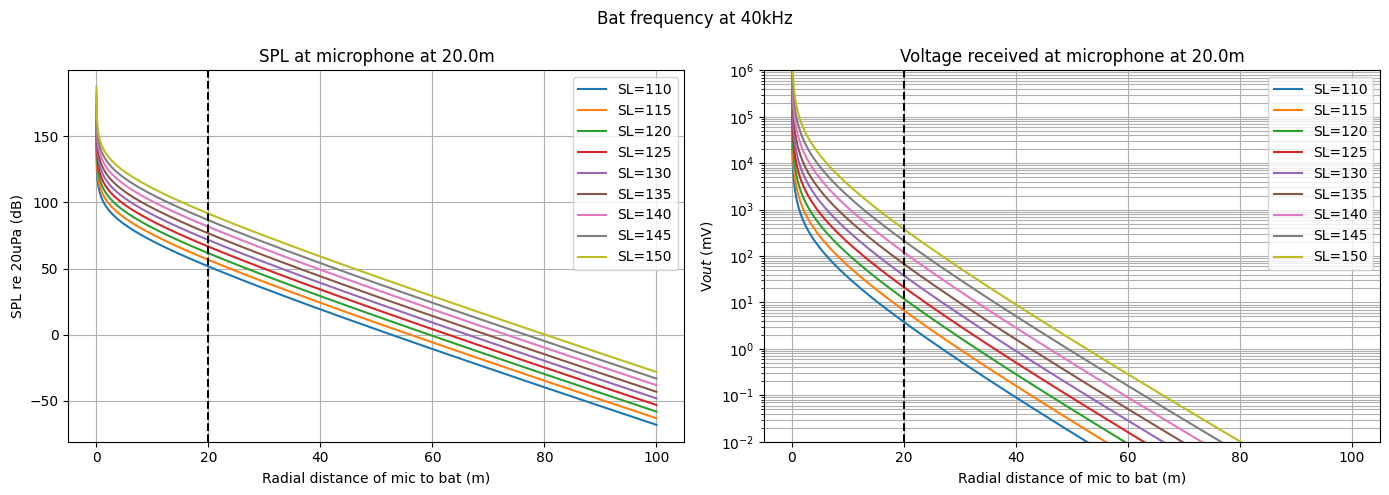

Voltages in mV: [[  3.79603873   6.75041751  12.00412846  21.34669447  37.96038726
   67.50417505 120.04128459 213.46694474 379.60387255]]


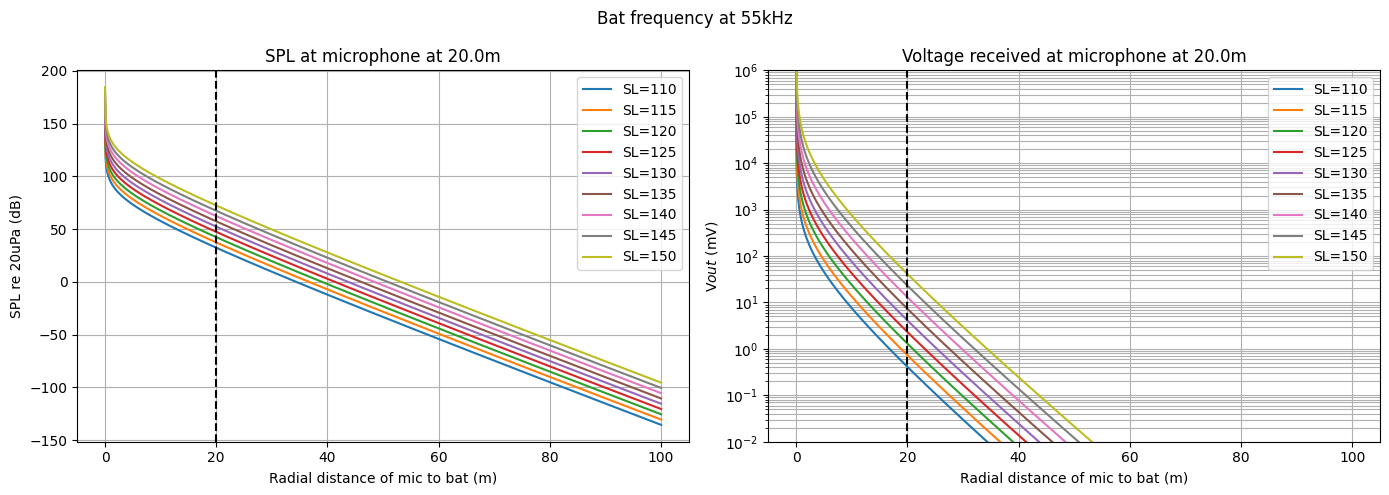

Voltages in mV: [[ 0.4121628   0.73294062  1.30337322  2.31776176  4.12162802  7.32940624
  13.03373221 23.17761763 41.2162802 ]]


In [16]:
for i in range(0, len(bat_frequencies)):
    dist = bat_dists[i]
    RLper20uPa = RL_dBs_for_bats[i]

    plt.figure(figsize=(14,5))
    plt.suptitle(f'Bat frequency at {bat_frequencies[i]//1000}kHz')
    plt.subplot(121)
    plt.title(f'SPL at microphone at {dist}m')
    plt.plot(respctive_r, RLper20uPa.T)
    plt.ylabel(r'SPL re 20uPa (dB)')
    plt.xlabel('Radial distance of mic to bat (m)')
    plt.axvline(x=dist, color='k', linestyle='dashed')
    plt.grid(which='both')
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    voltage_out = convertSPLtoV_at_dist(RLper20uPa, 20*np.log10(0.5), 0).T

    plt.subplot(122)
    plt.title(f'Voltage received at microphone at {dist}m')
    plt.plot(respctive_r, (voltage_out*1000))
    plt.ylabel(r'V$out$ (mV)')
    plt.xlabel('Radial distance of mic to bat (m)')
    plt.axvline(x=dist, color='k', linestyle='dashed')
    plt.grid(which='both')
    plt.yscale('log')
    plt.ylim(1e-2, 1e6)
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    plt.tight_layout()
    plt.show()
    print(f'Voltages in mV: {(1000*voltage_out[np.where(np.isclose(respctive_r,dist,atol=0.01))[0],:])}')

## Plugging in FG-23629-D65 Momimic mic sensitivity and gain settings 
#### Approximate Sensitivity: -55 dBV/0.1Pa, gain at 40dB

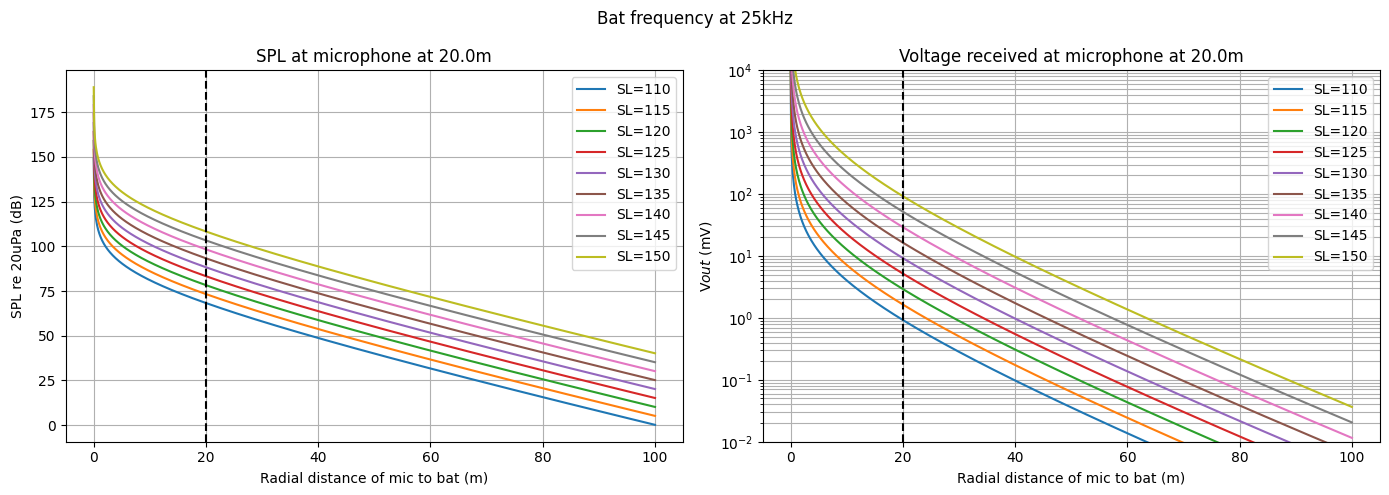

Voltages in mV: [[ 0.92603527  1.64674946  2.92838065  5.20747902  9.26035272 16.46749457
  29.28380652 52.07479019 92.60352717]]


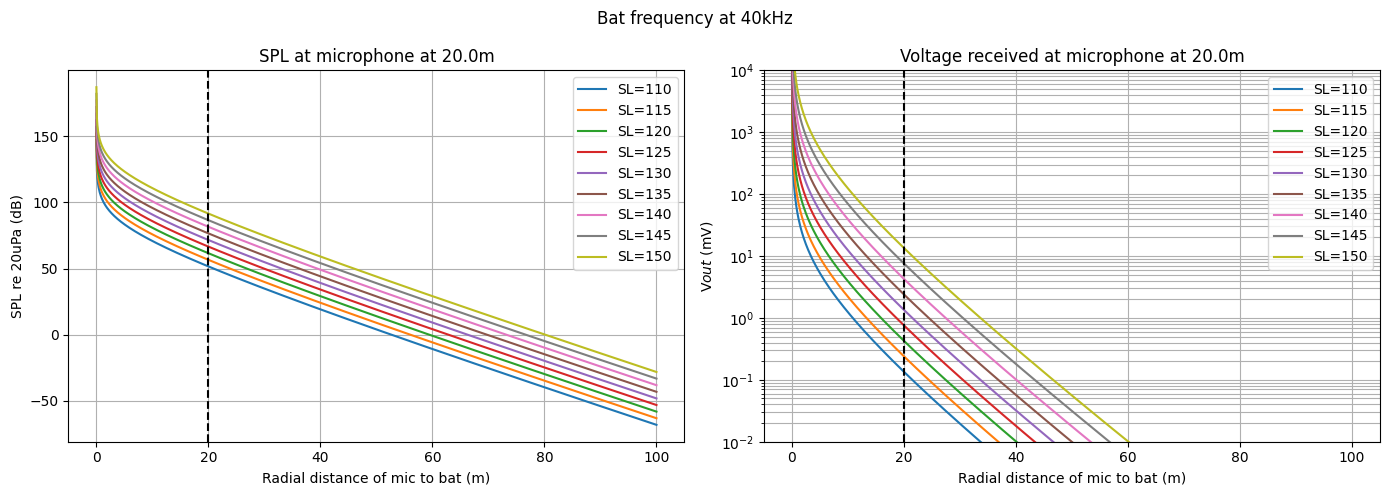

Voltages in mV: [[ 0.13500835  0.24008257  0.42693389  0.75920775  1.3500835   2.40082569
   4.26933889  7.59207745 13.50083501]]


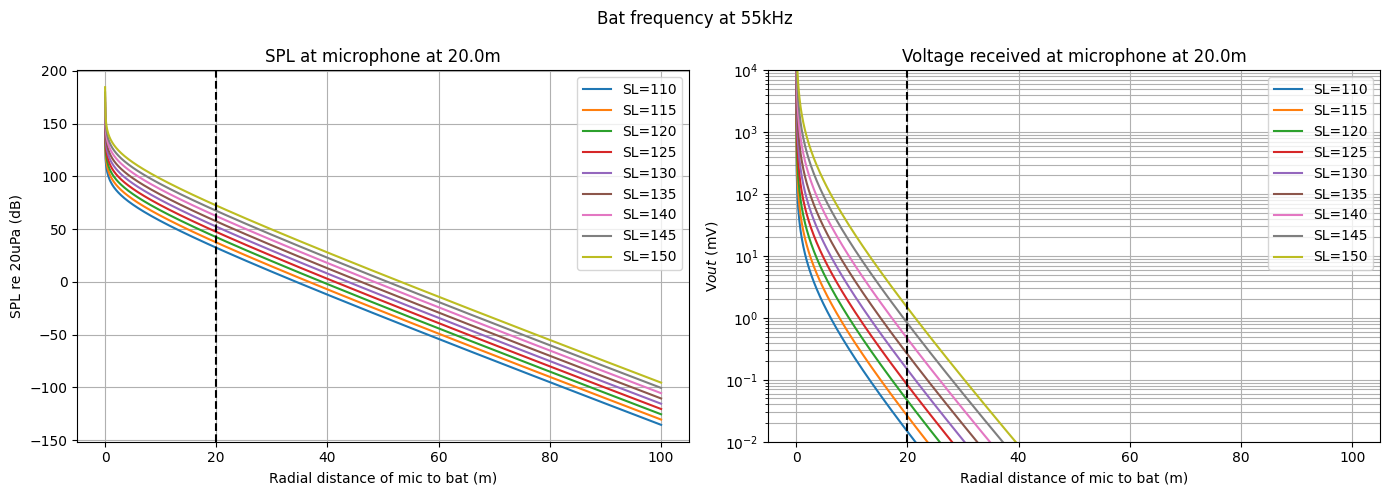

Voltages in mV: [[0.01465881 0.02606746 0.04635524 0.08243256 0.14658812 0.26067464
  0.46355235 0.8243256  1.46588125]]


In [17]:
for i in range(0, len(bat_frequencies)):
    dist = bat_dists[i]
    RLper20uPa = RL_dBs_for_bats[i]

    plt.figure(figsize=(14,5))
    plt.suptitle(f'Bat frequency at {bat_frequencies[i]//1000}kHz')
    plt.subplot(121)
    plt.title(f'SPL at microphone at {dist}m')
    plt.plot(respctive_r, RLper20uPa.T)
    plt.ylabel(r'SPL re 20uPa (dB)')
    plt.xlabel('Radial distance of mic to bat (m)')
    plt.axvline(x=dist, color='k', linestyle='dashed')
    plt.grid(which='both')
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    voltage_out = convertSPLtoV_at_dist(RLper20uPa, -55 - 20, 40).T

    plt.subplot(122)
    plt.title(f'Voltage received at microphone at {dist}m')
    plt.plot(respctive_r, (voltage_out*1000))
    plt.ylabel(r'V$out$ (mV)')
    plt.xlabel('Radial distance of mic to bat (m)')
    plt.axvline(x=dist, color='k', linestyle='dashed')
    plt.grid(which='both')
    plt.yscale('log')
    plt.ylim(1e-2, 1e4)
    bat_labels = []
    for batSL in bat_SL_in_dB:
        bat_labels += [f'SL={batSL}']
    plt.legend(labels=bat_labels)

    plt.tight_layout()
    plt.show()
    print(f'Voltages in mV: {(1000*voltage_out[np.where(np.isclose(respctive_r,dist,atol=0.01))[0],:])}')